In [71]:
%load_ext autoreload
%autoreload 2

import glob
from fibsem.segmentation.model import SegmentationModel
import tifffile as tf
import matplotlib.pyplot as plt

# load model
model = SegmentationModel(checkpoint="/home/patrick/github/fibsem/fibsem/segmentation/models/model.pt", num_classes=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
filenames = glob.glob("/home/patrick/github/data/training/images/*.tif")
print(len(filenames))

250


## Detection Goals


1. Detect Needle Tip
2. Detect Lamella Centre
3. Detect Lamella Edges (Right / Left, Up / Down)

account for multiple lamellas
mask centre?

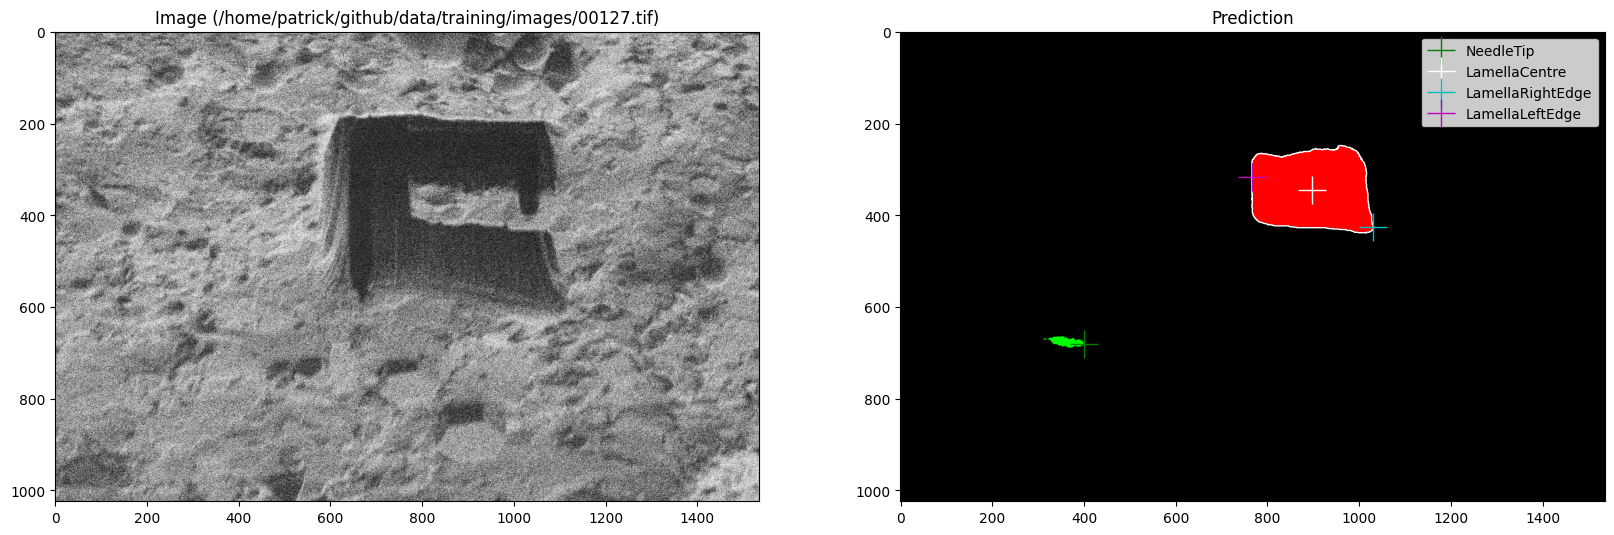

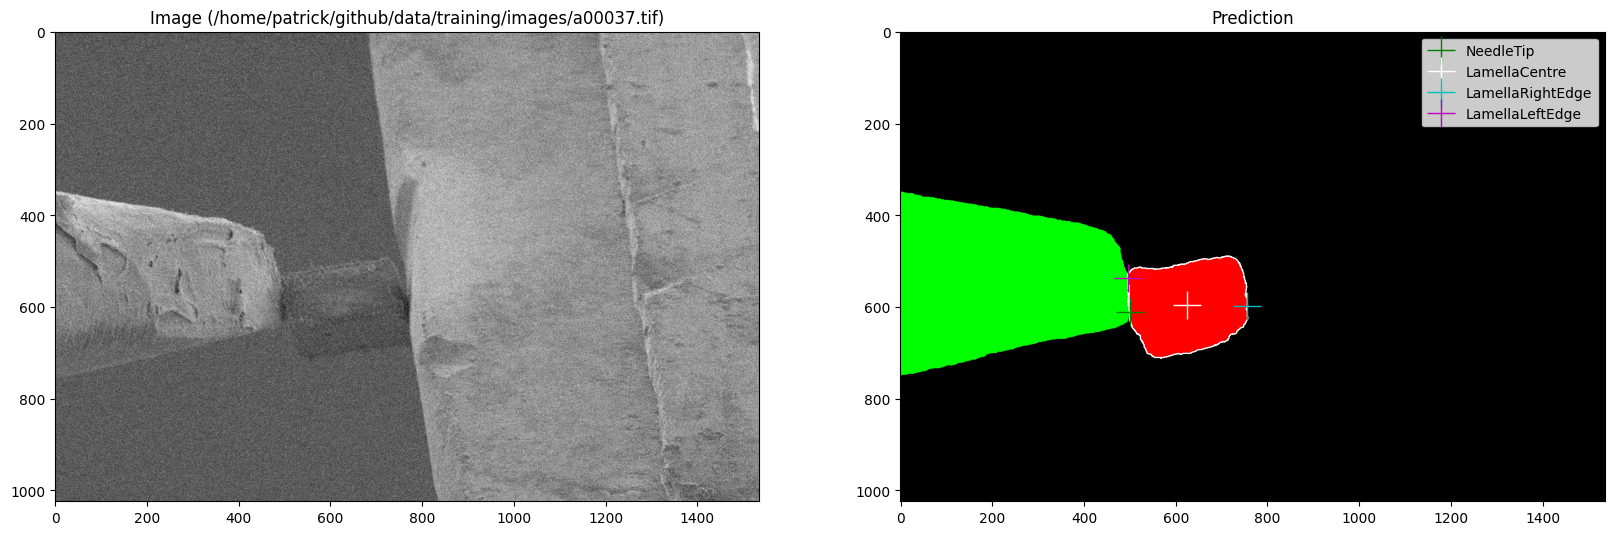

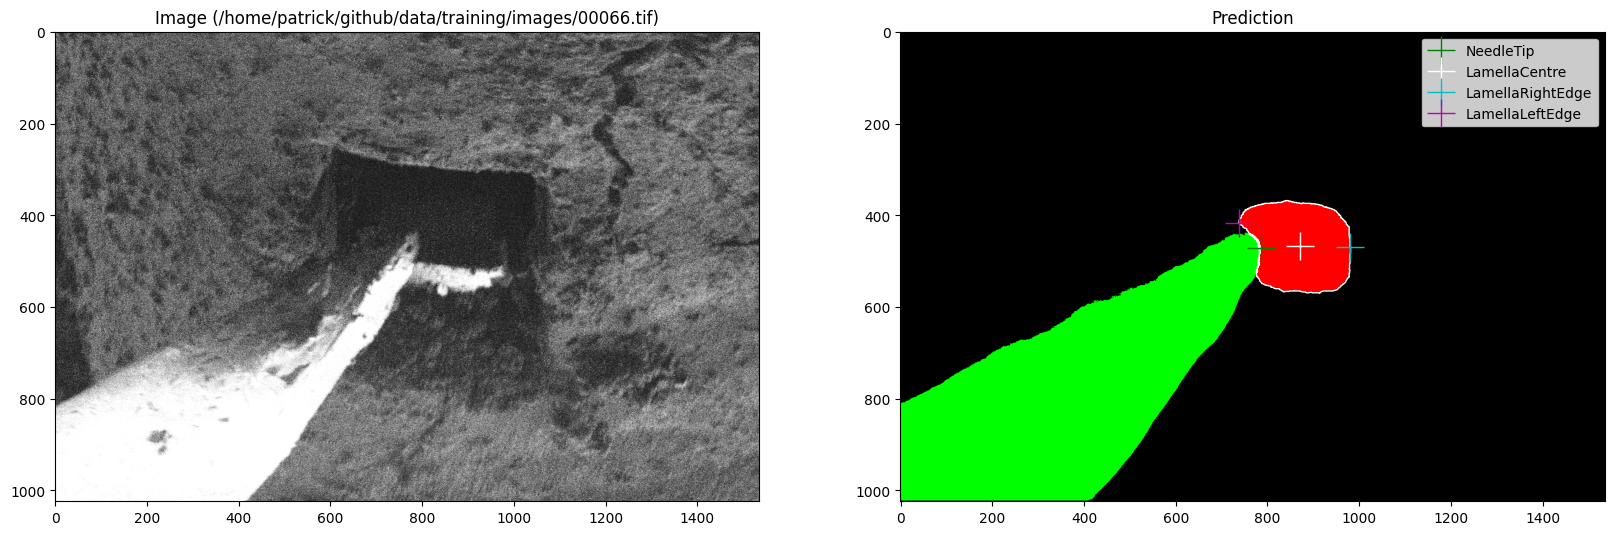

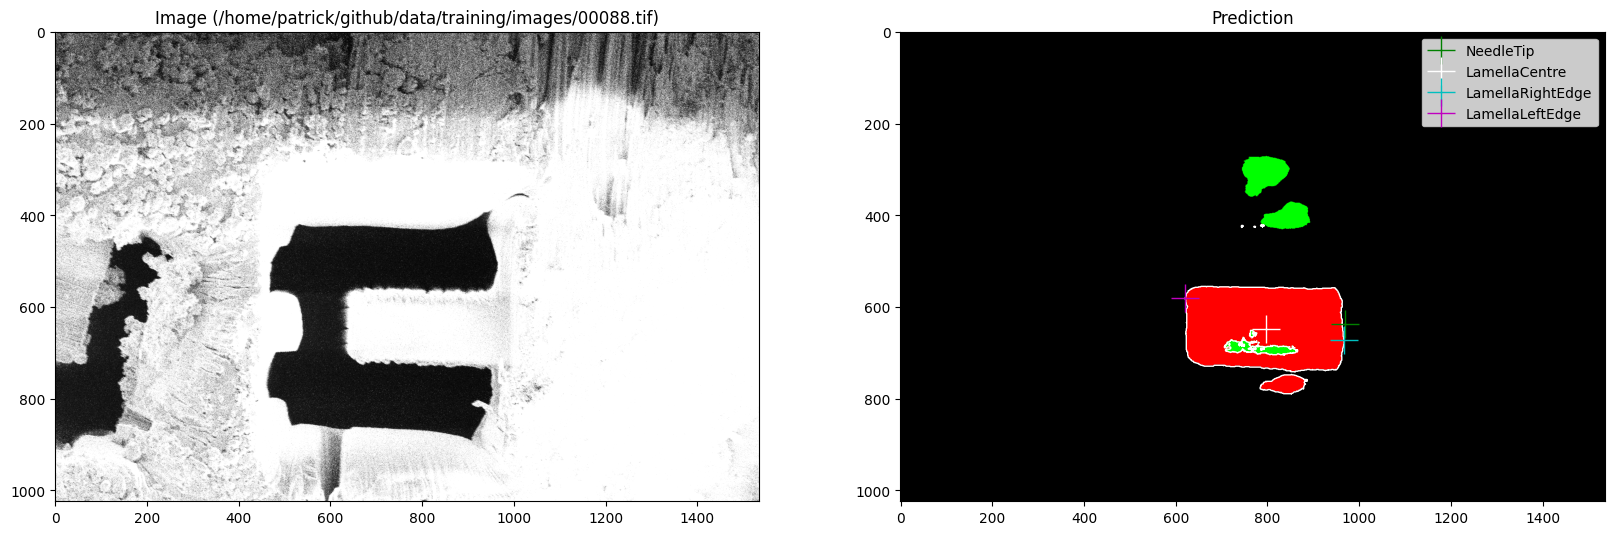

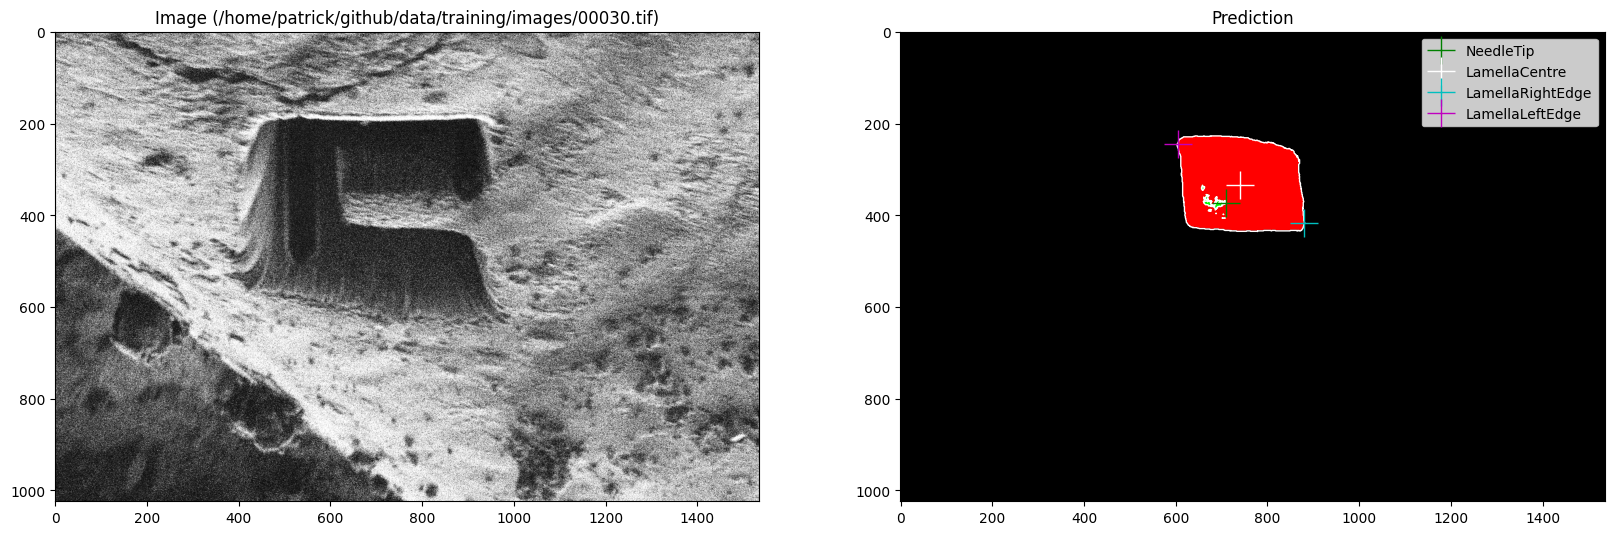

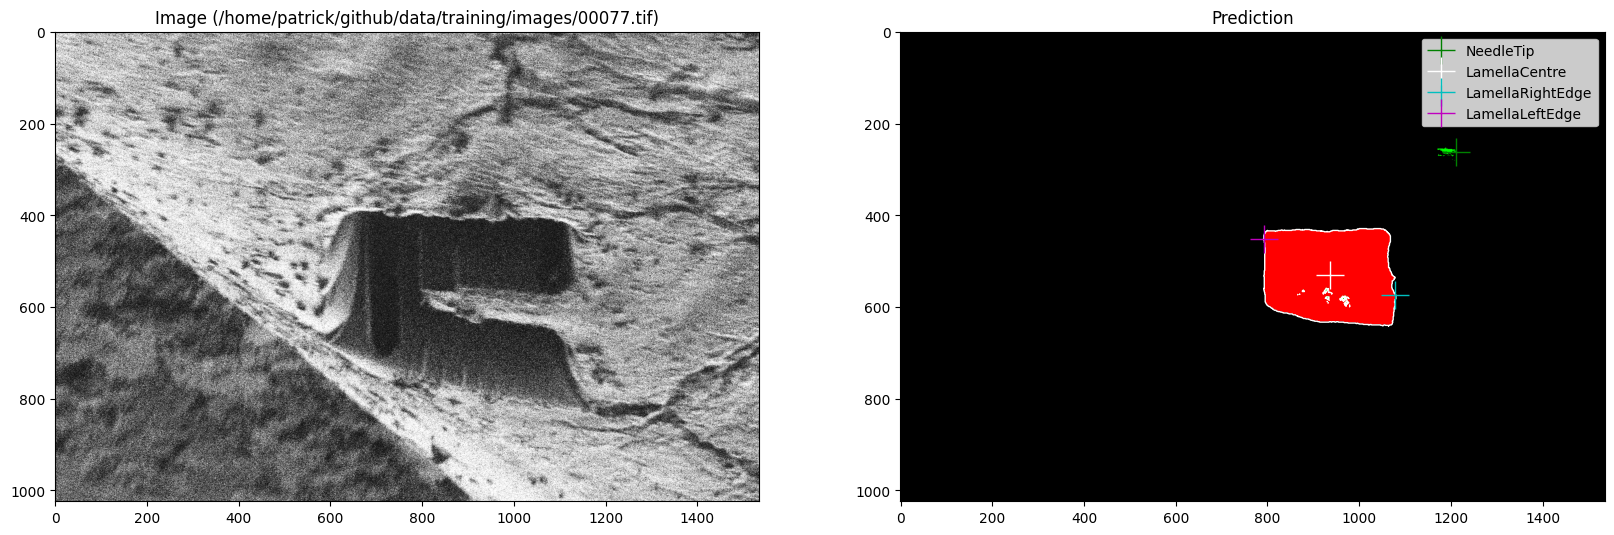

In [73]:

from random import shuffle

import numpy as np
from fibsem.detection.utils import DetectionFeature, DetectionType, DetectionResult, convert_pixel_distance_to_metres


from autoscript_sdb_microscope_client.structures import AdornedImage

from fibsem.structures import Point
from fibsem.imaging import masks
from fibsem.detection import detection
import skimage

def to_bounding_box(contour):
    # convert a contour to bounding box (xc, yc, w, h)
    # ref : https://muthu.co/draw-bounding-box-around-contours-skimage/
    # TODO: these dimensions are backwards, swap and fix the follow up

    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])

    w = (xmax - xmin)
    h = (ymax - ymin)
    xc = xmin + w // 2
    yc = ymin + h // 2
    
    return [xc, yc, w, h]
    


def detect_features_v2(img: np.ndarray, mask: np.ndarray, features: tuple[DetectionFeature]) -> list[DetectionFeature]:
    """
    img: raw image
    mask: rgb mask from model
    features: list of features to detect
    """
    detection_features = []

    for feature in features:
        
        det_type = feature.detection_type
        initial_point = feature.feature_px

        if not isinstance(det_type, DetectionType):
            raise TypeError(f"Detection Type {det_type} is not supported.")

        # get the initial position estimate
        if initial_point is None:
            initial_point = Point(x=img.shape[1]//2, y=img.shape[0]//2)

        if det_type == DetectionType.ImageCentre:
            feature_px = initial_point

        if det_type == DetectionType.NeedleTip:
            feature_px = detection.detect_needle_v4(mask)

        if det_type in [DetectionType.LamellaCentre, DetectionType.LamellaLeftEdge, DetectionType.LamellaRightEdge]:
            feature_px = detection.detect_lamella(mask, det_type)

        if det_type == DetectionType.LandingPost:
            feature_px = detection.detect_landing_post_v3(img, initial_point)

        detection_features.append(
            DetectionFeature(detection_type=det_type, feature_px=feature_px)
        )

    return detection_features

def locate_shift_between_features_v2(adorned_img: AdornedImage, model: SegmentationModel, features: tuple[DetectionFeature]):
    """
    Calculate the distance between two features in the image coordinate system.

    args:
        adorned_img: input image (AdornedImage)
        ref_img: the reference image to align (AdornedImage)
        shift_type: the type of feature detection shift to calculation

    return:
        detection_result (DetectionResult): The detection result containing the feature coordinates, and images

    """

    # TODO: do we need the adorned image here? or just pixelsize?
    # Cam DetectionResult be refactored now?

    # model inference
    mask = model.inference(adorned_img.data)

    # detect features for calculation
    feature_1, feature_2 = detect_features_v2(adorned_img.data, mask, features)

    # calculate movement distance
    x_distance_m, y_distance_m = convert_pixel_distance_to_metres(
        feature_1.feature_px, feature_2.feature_px, adorned_img
    )

    detection_result = DetectionResult(
        features=[feature_1, feature_2],
        adorned_image=adorned_img,
        display_image=adorned_img.data,
        distance_metres=Point(x_distance_m, y_distance_m),
        microscope_coordinate=[Point(0, 0), Point(0, 0)],
    )

    return detection_result

shuffle(filenames)
for i, fname in enumerate(filenames):

    img = tf.imread(fname)

    # inference
    mask = model.inference(img)
    mask = mask[0]

    # TODO: should these be binary?? probs easier

    # for plotting
    needle_mask, _ = detection.extract_class_pixels(mask, (0, 255, 0))
    lamella_mask, _ = detection.extract_class_pixels(mask, (255, 0, 0))
    lamella_mask = masks.apply_circular_mask(lamella_mask, radius=512)

    feature_types = [DetectionFeature(DetectionType.NeedleTip,None), 
                    DetectionFeature(DetectionType.LamellaCentre, None),
                    DetectionFeature(DetectionType.LamellaLeftEdge,None),  
                    DetectionFeature(DetectionType.LamellaRightEdge, None)]
    detection_features = detect_features_v2(img, mask, features=feature_types)

    needle_tip, lamella_centre, lamella_left_edge, lamella_right_edge = detection_features


    # options for getting individual lamella from multiple: contours, masking 
    bboxes = []
    contours = skimage.measure.find_contours(lamella_mask[:, :, 0].astype(np.uint8), 0.8)

    for contour in contours:
        bboxes.append(to_bounding_box(contour))
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(f"Image ({fname})")
    ax[1].imshow(mask)
    ax[1].set_title("Prediction")
    for contour in contours:
        ax[1].plot(contour[:, 1], contour[:, 0], color="white", linewidth=1)
    ax[1].plot(needle_tip.feature_px.x, needle_tip.feature_px.y, "g+", ms=20, label=needle_tip.detection_type.name)
    ax[1].plot(lamella_centre.feature_px.x, lamella_centre.feature_px.y, "w+", ms=20, label=lamella_centre.detection_type.name)
    ax[1].plot(lamella_right_edge.feature_px.x, lamella_right_edge.feature_px.y, "c+", ms=20, label=lamella_right_edge.detection_type.name)
    ax[1].plot(lamella_left_edge.feature_px.x, lamella_left_edge.feature_px.y, "m+", ms=20, label=lamella_left_edge.detection_type.name)
    ax[1].legend(loc="best")
    plt.show()


    if i == 5:
        break
